In [1]:
from ncut_feature import *
import cv2
from ncut_pytorch import rgb_from_tsne_3d

In [2]:
# target_folder = "test_long_text_small_image"
# target_folder = "test_long_text_mid_image"
# target_folder = "test_short_text_small_image"
# target_folder = "test_short_text_mid_image"
# target_folder = "test_mid_text_small_image"
# target_folder = "test_mid_text_mid_image"

target_folder = "test_finetune_sd3_yh_sm"

feature_path = f"{target_folder}/feature_maps"
x_feature_maps, c_feature_maps = get_feature_maps(feature_path)

In [3]:
batch_no = 0
steps = list(x_feature_maps.keys())
tokens = list(c_feature_maps[steps[0]][batch_no].keys())

num_eig = 100
num_steps = len(steps)
num_tokens = len(tokens)
x_size = x_feature_maps[steps[0]][batch_no].shape[0] # 400
x_height = int(np.sqrt(x_size)) # 20
x_width = x_size // x_height # 20
x_dim = x_feature_maps[steps[0]][batch_no].shape[1] # 1536
c_dim = c_feature_maps[steps[0]][batch_no][tokens[0]].shape[0] # 1536

print(f"Image Feature Map Size: ({x_height}x{x_width})x{x_dim} = {x_size}x{x_dim}")
print(f"Text Feature Map Size: {num_tokens}x{c_dim}")

x_features = group_x_features(x_feature_maps, batch_no)
c_features = group_c_features(c_feature_maps, batch_no)
xc_features = torch.concat([x_features, c_features], dim=0) # [num_steps * (x_size + num_tokens), x_dim]
xc_eign_vec, xc_eign_val = ncut_features(xc_features, num_eig)

Image Feature Map Size: (20x20)x1536 = 400x1536
Text Feature Map Size: 6x1536


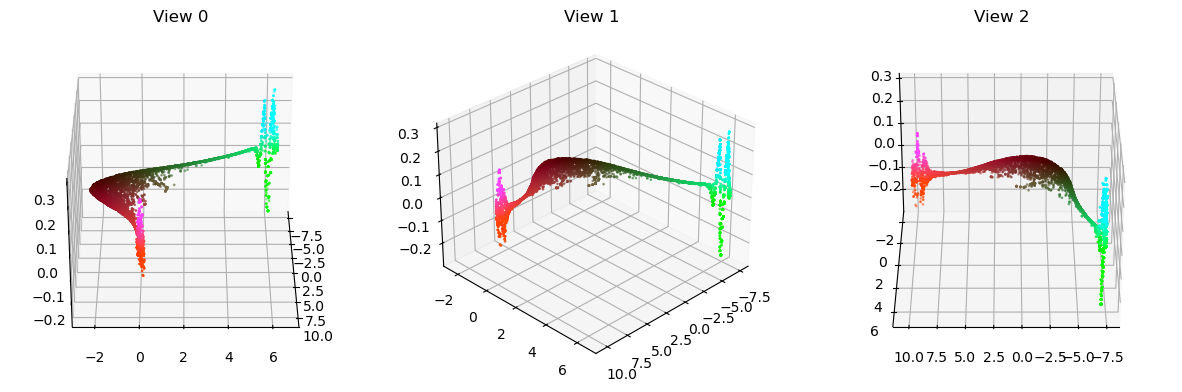

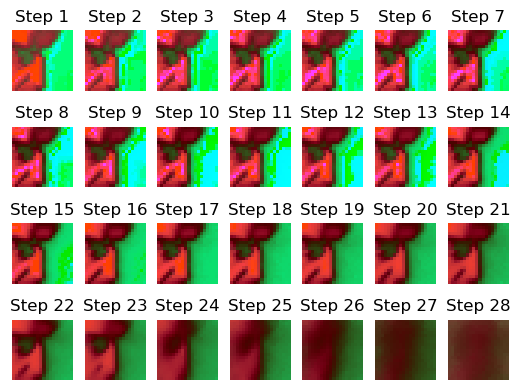

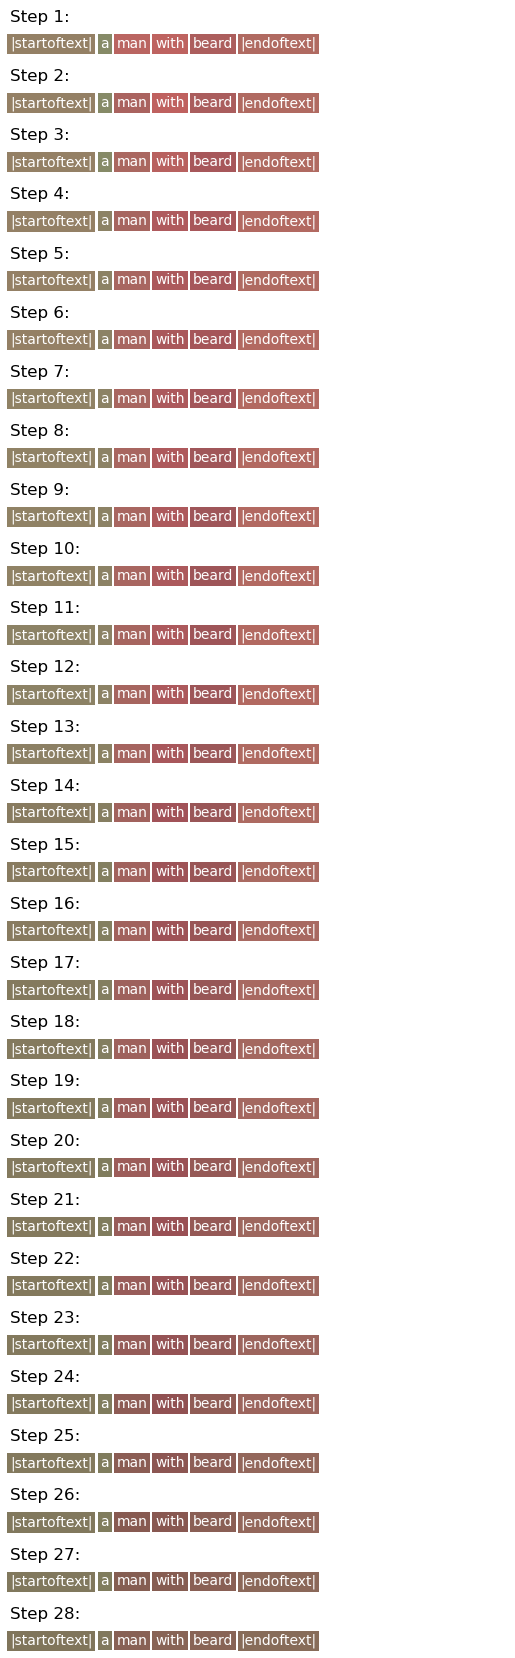

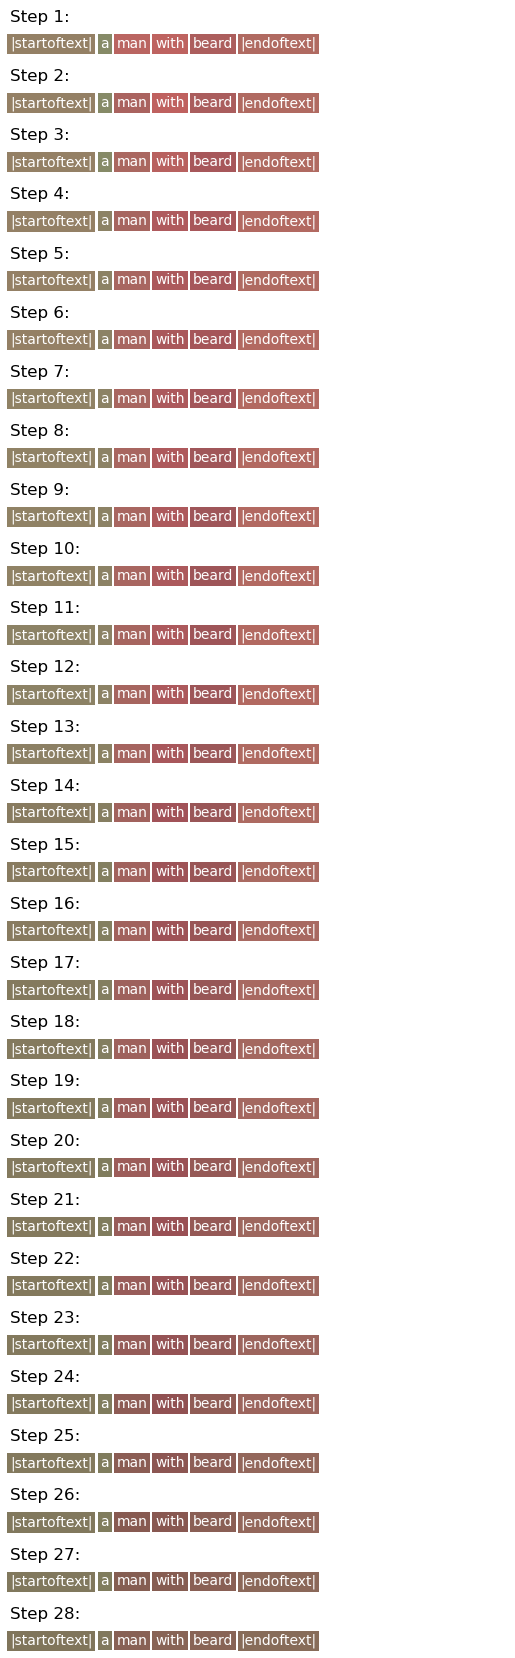

In [9]:
select_eign = 3
xc_3d, xc_rgb = rgb_from_tsne_3d(xc_eign_vec[:, :select_eign])
title = f"{select_eign} Eigenvectors of NCUT SD3 Image and Text Features"
title = ""
plot_3d(xc_3d,xc_rgb, title, num_nodes=num_steps * (x_size + num_tokens))
xc_x_features_rgb = xc_rgb[:num_steps*x_size].reshape(num_steps, x_height, x_width, 3).numpy()
xc_c_features_rgb = xc_rgb[num_steps*x_size:].reshape(num_steps, num_tokens, 3).numpy()
plot_images(xc_x_features_rgb, title)
plot_texts(xc_c_features_rgb, tokens, title)

In [ ]:
def pad_image(image, target_height, target_width):
    """Pad an image to the target size without deformation."""
    h, w, _ = image.shape
    top = (target_height - h) // 2
    bottom = target_height - h - top
    left = (target_width - w) // 2
    right = target_width - w - left
    if top < 0 or bottom < 0 or left < 0 or right < 0:
        print(f"Warning: Padding values are negative: top={top}, bottom={bottom}, left={left}, right={right}")
        raise ValueError("Padding values must be non-negative")
    return cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[255, 255, 255])

output_video = f"{target_folder}/output_video_60.mp4"
# output_video = f"{target_folder}/output_video_60_3.mp4"
fps = 1
frame_width = 1280
frame_height = 720

fourcc = cv2.VideoWriter_fourcc(*"mp4v")
video_writer = cv2.VideoWriter(output_video, fourcc, fps, (frame_width, frame_height))

for select_eign in range(3, 61):
    xc_3d, xc_rgb = rgb_from_tsne_3d(xc_eign_vec[:, :select_eign])
    # xc_3d, xc_rgb = rgb_from_tsne_3d(xc_eign_vec[:, select_eign - 3 : select_eign])
    fig1 = plot_3d(xc_3d,xc_rgb,f"{select_eign} Eigenvectors of NCUT SD3 Image and Text Features",num_nodes=num_steps * (x_size + num_tokens), show=False)
    xc_x_features_rgb = xc_rgb[:num_steps*x_size].reshape(num_steps, x_height, x_width, 3).numpy()
    xc_c_features_rgb = xc_rgb[num_steps*x_size:].reshape(num_steps, num_tokens, 3).numpy()
    fig2 = plot_images(xc_x_features_rgb, f"{select_eign} Eigenvectors of NCUT SD3 Image Features", show=False)
    fig3 = plot_texts(xc_c_features_rgb, tokens, f"{select_eign} Eigenvectors of NCUT SD3 Text Features", show=False)

    fig1.savefig(f"{target_folder}/3d_{select_eign}.png")
    fig2.savefig(f"{target_folder}/image_{select_eign}.png")
    fig3.savefig(f"{target_folder}/text_{select_eign}.png")
    plt.close('all')

    img1 = cv2.imread(f"{target_folder}/3d_{select_eign}.png")
    img2 = cv2.imread(f"{target_folder}/image_{select_eign}.png")
    img3 = cv2.imread(f"{target_folder}/text_{select_eign}.png")

    h1, w1, _ = img1.shape 
    h2, w2, _ = img2.shape
    h3, w3, _ = img3.shape

    max_lower_height = max(h2, h3)
    img2_padded = pad_image(img2, max_lower_height, w2)
    img3_padded = pad_image(img3, max_lower_height, w3)
    img23 = np.hstack((img2_padded, img3_padded))
    h23, w23, _ = img23.shape 

    max_width = max(w1, w23)
    img1_padded = pad_image(img1, h1, max_width)
    img23_padded = pad_image(img23, h23, max_width)
    img123 = np.vstack((img1_padded, img23_padded))

    target_aspect_ratio = frame_width / frame_height
    h123, w123, _ = img123.shape
    img_aspect_ratio = w123 / h123
    # print("Resize from", w123, h123, "to", end=" ")
    if img_aspect_ratio > target_aspect_ratio:
        h123 = int(w123 / target_aspect_ratio)
    else:
        w123 = int(h123 * target_aspect_ratio)
    # print(w123, h123)
    img123_padded = pad_image(img123, h123, w123)

    final_img123 = cv2.resize(img123_padded, (frame_width, frame_height))

    video_writer.write(final_img123)
    print(f"Get result for {select_eign} eigenvectors", end="\r")
    # os.remove(f"{target_folder}/3d_{select_eign}.png")
    # os.remove(f"{target_folder}/image_{select_eign}.png")
    # os.remove(f"{target_folder}/text_{select_eign}.png")
print("Video saved to ", output_video)
video_writer.release()